### The goal of this notebook is to combine the 4 perspectives that were created in order to obtain final clusters that characterize the customers and allow the definition of marketing strategies.

The four perspectives are:

- Behavioral
- Loyalty
- Value Based
- Seasonal

In [34]:
import pandas as pd
import numpy as np
# Custom Modules
import sys

from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import RobustScaler

In [35]:
df = pd.read_csv("df_ready_for_clustering.csv")
df.head()

PointsRedeemedRatio  FlightsWithCompanionsRatio  AvgDistancePerFlight  \
0             0.387904                    0.200000           2356.577778   
1             0.553363                    0.224490           1384.141224   
2             0.113362                    0.241706           2047.539336   
3             0.354092                    0.157407           3375.941667   
4             0.253580                    0.276243           2373.649171   

   KMPerRedeemedPoint  UnredeemedPoints  LoyaltyIndex  \
0           25.786888             32446    709.589704   
1           18.077435             15141    418.130598   
2           88.241585             38293    616.640254   
3           28.248369             23544   1014.088728   
4           39.448214             32058    714.181936   

                       CustomerSegment  HasBonus  TotalFlights    sr_jan  ...  \
0  Moderate traveler and high redeemed         0           225  0.026667  ...   
1        Low traveler and low redeemed         0           245  0.077551  ...   
2   Moderate traveler and low redeemed         0           211  0.094787  ...   
3      High traveler and high redeemed         0           108  0.000000  ...   
4  Moderate traveler and high redeemed         0           181  0.022099  ...   

   Education   Income  Marital Status  LoyaltyStatus  EnrollmentMonth  \
0   Bachelor  82877.0         Married         Aurora                8   
1    College      0.0          Single           Nova                3   
2    College      0.0        Divorced           Nova                7   
3   Bachelor  42837.0         Married           Star                8   
4   Bachelor  80979.0        Divorced           Star                1   

   Time on Program  Cancelled  Reenroll  EnrollmentType  \
0              874          N         0        Standard   
1             2122          N         0        Standard   
2              884          N         0        Standard   
3             1242          N         0        Standard   
4             1816          N         0        Standard   

   Customer Lifetime Value  
0                  7919.20  
1                  2887.74  
2                  2838.07  
3                  4170.57  
4                  6622.05  

[5 rows x 32 columns]

In [36]:
df.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'LoyaltyIndex', 'CustomerSegment', 'HasBonus', 'TotalFlights', 'sr_jan',
       'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul', 'sr_aug',
       'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec', 'Province or State',
       'Education', 'Income', 'Marital Status', 'LoyaltyStatus',
       'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll',
       'EnrollmentType', 'Customer Lifetime Value'],
      dtype='object')

In [37]:
# Define column types
binary_columns = ['EnrollmentType', 'Cancelled']
frequency_column = 'Province or State'
onehot_columns = ['CustomerSegment', 'Education', 'Marital Status', 'LoyaltyStatus']

# Get numerical columns (exclude categorical, datetime, and timedelta columns)
all_categorical = binary_columns + [frequency_column] + onehot_columns

# Identify datetime and timedelta columns to exclude
datetime_cols = df.select_dtypes(include=['datetime64', 'timedelta64']).columns.tolist()

# Get only numeric columns that are not categorical or datetime
numerical_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in all_categorical]

# 1. MINMAX SCALING on numerical columns directly in df
if len(numerical_cols) > 0:
    scaler = MinMaxScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# 2. BINARY ENCODING directly in df
#for col in binary_columns:
#    if col in df.columns:
#        df[col] = (df[col] == df[col].unique()[1]).astype(int)

# Frequency encoding
#if frequency_column in df.columns:
#    freq_map = df[frequency_column].value_counts(normalize=True)
#    df[frequency_column] = df[frequency_column].map(freq_map)

# 4. ONE-HOT ENCODING directly in df
#for col in onehot_columns:
#    if col in df.columns:
#        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
#        dummies = dummies.astype(int)
#        df.drop(col, axis=1, inplace=True)
#        for dummy_col in dummies.columns:
#            df[dummy_col] = dummies[dummy_col]

# 5. CONVERT ALL REMAINING BOOLEAN COLUMNS TO INT
#bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
#if len(bool_cols) > 0:
 #   df[bool_cols] = df[bool_cols].astype(int)

#print("\n" + "="*60)
#print(f"Transformation complete")
#print(f"Final df shape: {df.shape}")
#print(f"Datetime columns kept as-is: {datetime_cols}")
#print(f"NaN count: {df.isnull().sum().sum()}")
#print(f"\nData types in df:")
#print(df.dtypes.value_counts())
df.head()

PointsRedeemedRatio  FlightsWithCompanionsRatio  AvgDistancePerFlight  \
0             0.011660                    0.200000              0.053732   
1             0.016634                    0.224490              0.031560   
2             0.003408                    0.241706              0.046686   
3             0.010644                    0.157407              0.076975   
4             0.007622                    0.276243              0.054122   

   KMPerRedeemedPoint  UnredeemedPoints  LoyaltyIndex  \
0            0.101416          0.497569      0.053931   
1            0.071096          0.232192      0.031779   
2            0.347041          0.587235      0.046867   
3            0.111097          0.361054      0.077074   
4            0.155144          0.491619      0.054280   

                       CustomerSegment  HasBonus  TotalFlights    sr_jan  ...  \
0  Moderate traveler and high redeemed       0.0      0.655977  0.026667  ...   
1        Low traveler and low redeemed       0.0      0.714286  0.077551  ...   
2   Moderate traveler and low redeemed       0.0      0.615160  0.094787  ...   
3      High traveler and high redeemed       0.0      0.314869  0.000000  ...   
4  Moderate traveler and high redeemed       0.0      0.527697  0.022099  ...   

   Education    Income  Marital Status  LoyaltyStatus  EnrollmentMonth  \
0   Bachelor  0.828927         Married         Aurora         0.636364   
1    College  0.000000          Single           Nova         0.181818   
2    College  0.000000        Divorced           Nova         0.545455   
3   Bachelor  0.428451         Married           Star         0.636364   
4   Bachelor  0.809944        Divorced           Star         0.000000   

   Time on Program  Cancelled  Reenroll  EnrollmentType  \
0         0.354564          N       0.0        Standard   
1         0.860852          N       0.0        Standard   
2         0.358621          N       0.0        Standard   
3         0.503854          N       0.0        Standard   
4         0.736714          N       0.0        Standard   

   Customer Lifetime Value  
0                 0.073946  
1                 0.012155  
2                 0.011545  
3                 0.027909  
4                 0.058015  

[5 rows x 32 columns]

## Value Based and Loyalty

In [38]:
value_based_cluster = pd.read_csv("value_based_clusters.csv")
value_based_cluster.head()

kr3_cluster
0            0
1            0
2            1
3            0
4            0

In [39]:
loyalty_cluster = pd.read_csv("loyalty_cluster.csv")
loyalty_cluster.drop(columns=['Unnamed: 0'], inplace=True)
loyalty_cluster.head()

hierarchical_cluster
0                     0
1                     0
2                     0
3                     1
4                     0

In [40]:
# VB_col is the list of columns related to value-based perspective
VB_col = [

    'Customer Lifetime Value',
    'UnredeemedPoints',
    'PointsRedeemedRatio',
    'KMPerRedeemedPoint'
]

LO_col = ['LoyaltyIndex', 'Time on Program', 'HasBonus', 'EnrollmentMonth']


In [41]:
df["VALUE_BASED_CLUSTER"] = value_based_cluster["kr3_cluster"]
df["LOYALTY_CLUSTER"] = loyalty_cluster["hierarchical_cluster"]
df.head()

PointsRedeemedRatio  FlightsWithCompanionsRatio  AvgDistancePerFlight  \
0             0.011660                    0.200000              0.053732   
1             0.016634                    0.224490              0.031560   
2             0.003408                    0.241706              0.046686   
3             0.010644                    0.157407              0.076975   
4             0.007622                    0.276243              0.054122   

   KMPerRedeemedPoint  UnredeemedPoints  LoyaltyIndex  \
0            0.101416          0.497569      0.053931   
1            0.071096          0.232192      0.031779   
2            0.347041          0.587235      0.046867   
3            0.111097          0.361054      0.077074   
4            0.155144          0.491619      0.054280   

                       CustomerSegment  HasBonus  TotalFlights    sr_jan  ...  \
0  Moderate traveler and high redeemed       0.0      0.655977  0.026667  ...   
1        Low traveler and low redeemed       0.0      0.714286  0.077551  ...   
2   Moderate traveler and low redeemed       0.0      0.615160  0.094787  ...   
3      High traveler and high redeemed       0.0      0.314869  0.000000  ...   
4  Moderate traveler and high redeemed       0.0      0.527697  0.022099  ...   

   Marital Status  LoyaltyStatus  EnrollmentMonth  Time on Program  Cancelled  \
0         Married         Aurora         0.636364         0.354564          N   
1          Single           Nova         0.181818         0.860852          N   
2        Divorced           Nova         0.545455         0.358621          N   
3         Married           Star         0.636364         0.503854          N   
4        Divorced           Star         0.000000         0.736714          N   

   Reenroll  EnrollmentType  Customer Lifetime Value  VALUE_BASED_CLUSTER  \
0       0.0        Standard                 0.073946                    0   
1       0.0        Standard                 0.012155                    0   
2       0.0        Standard                 0.011545                    1   
3       0.0        Standard                 0.027909                    0   
4       0.0        Standard                 0.058015                    0   

   LOYALTY_CLUSTER  
0                0  
1                0  
2                0  
3                1  
4                0  

[5 rows x 34 columns]

In [42]:
print(df.columns.tolist())


['PointsRedeemedRatio', 'FlightsWithCompanionsRatio', 'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints', 'LoyaltyIndex', 'CustomerSegment', 'HasBonus', 'TotalFlights', 'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec', 'Province or State', 'Education', 'Income', 'Marital Status', 'LoyaltyStatus', 'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll', 'EnrollmentType', 'Customer Lifetime Value', 'VALUE_BASED_CLUSTER', 'LOYALTY_CLUSTER']


In [43]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['VALUE_BASED_CLUSTER', 'LOYALTY_CLUSTER'])\
    [VB_col + LO_col].mean()
df_centroids

Customer Lifetime Value  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                            
0                   0                               0.073843   
                    1                               0.073266   
                    2                               0.071663   
                    3                               0.076138   
1                   0                               0.070032   
                    1                               0.074613   
                    2                               0.072273   
                    3                               0.076183   
2                   0                               0.102134   
                    1                               0.089988   
                    2                               0.101063   
                    3                               0.112386   
3                   0                               0.073545   
                    1                               0.096616   
                    2                               0.119924   
                    3                               0.022687   

                                     UnredeemedPoints  PointsRedeemedRatio  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                          
0                   0                        0.309540             0.007471   
                    1                        0.262798             0.006542   
                    2                        0.399926             0.008373   
                    3                        0.000000             0.051714   
1                   0                        0.327011             0.007187   
                    1                        0.280179             0.006452   
                    2                        0.422161             0.008026   
                    3                        0.000000             0.072268   
2                   0                        0.316736             0.007744   
                    1                        0.285063             0.006345   
                    2                        0.381784             0.008390   
                    3                        0.000000             0.042948   
3                   0                        0.202905             0.010323   
                    1                        0.262644             0.013078   
                    2                        0.314389             0.010173   
                    3                        0.000000             0.044126   

                                     KMPerRedeemedPoint  LoyaltyIndex  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                     
0                   0                          0.103555      0.045040   
                    1                          0.089766      0.045554   
                    2                          0.136131      0.045971   
                    3                          0.028431      0.046186   
1                   0                          0.124138      0.046059   
                    1                          0.108057      0.046647   
                    2                          0.160741      0.046969   
                    3                          0.027560      0.053148   
2                   0                          0.115838      0.046369   
                    1                          0.102772      0.048252   
                    2                          0.136268      0.045064   
                    3                          0.031049      0.041708   
3                   0                          0.093714      0.039116   
                    1                          0.099148      0.061207   
                    2                          0.117094      0.043346   
                    3                          0.026801      0.958271   

                                     Time on Program  HasBonus  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                              
0                   0           

Text(0, 0.5, 'Euclidean Distance')

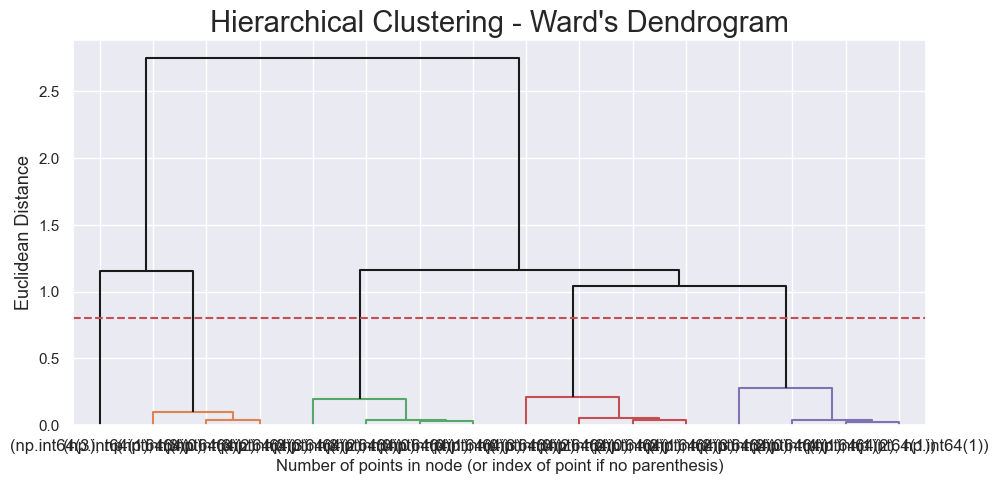

In [44]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 0.8
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)

In [88]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters= 4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

Customer Lifetime Value  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                            
0                   0                               0.073843   
                    1                               0.073266   
                    2                               0.071663   
                    3                               0.076138   
1                   0                               0.070032   
                    1                               0.074613   
                    2                               0.072273   
                    3                               0.076183   
2                   0                               0.102134   
                    1                               0.089988   
                    2                               0.101063   
                    3                               0.112386   
3                   0                               0.073545   
                    1                               0.096616   
                    2                               0.119924   
                    3                               0.022687   

                                     UnredeemedPoints  PointsRedeemedRatio  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                          
0                   0                        0.309540             0.007471   
                    1                        0.262798             0.006542   
                    2                        0.399926             0.008373   
                    3                        0.000000             0.051714   
1                   0                        0.327011             0.007187   
                    1                        0.280179             0.006452   
                    2                        0.422161             0.008026   
                    3                        0.000000             0.072268   
2                   0                        0.316736             0.007744   
                    1                        0.285063             0.006345   
                    2                        0.381784             0.008390   
                    3                        0.000000             0.042948   
3                   0                        0.202905             0.010323   
                    1                        0.262644             0.013078   
                    2                        0.314389             0.010173   
                    3                        0.000000             0.044126   

                                     KMPerRedeemedPoint  LoyaltyIndex  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                                     
0                   0                          0.103555      0.045040   
                    1                          0.089766      0.045554   
                    2                          0.136131      0.045971   
                    3                          0.028431      0.046186   
1                   0                          0.124138      0.046059   
                    1                          0.108057      0.046647   
                    2                          0.160741      0.046969   
                    3                          0.027560      0.053148   
2                   0                          0.115838      0.046369   
                    1                          0.102772      0.048252   
                    2                          0.136268      0.045064   
                    3                          0.031049      0.041708   
3                   0                          0.093714      0.039116   
                    1                          0.099148      0.061207   
                    2                          0.117094      0.043346   
                    3                          0.026801      0.958271   

                                     Time on Program  HasBonus  \
VALUE_BASED_CLUSTER LOYALTY_CLUSTER                              
0                   0           

In [89]:
df_ = df.copy()
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper
# Mapping the hierarchical clusters on the centroids to the observations
df_['Merged_Cluster_1'] = df_.apply(
    lambda row: cluster_mapper[
        (row['VALUE_BASED_CLUSTER'], row['LOYALTY_CLUSTER'])
    ], axis=1
)

df_ 

PointsRedeemedRatio  FlightsWithCompanionsRatio  AvgDistancePerFlight  \
0                 0.011660                    0.200000              0.053732   
1                 0.016634                    0.224490              0.031560   
2                 0.003408                    0.241706              0.046686   
3                 0.010644                    0.157407              0.076975   
4                 0.007622                    0.276243              0.054122   
...                    ...                         ...                   ...   
16569             0.005174                    0.275862              0.053304   
16570             0.000000                    0.000000              0.000000   
16571             0.007082                    0.321429              0.064760   
16572             0.000000                    0.090909              0.054571   
16573             0.015725                    0.121547              0.043475   

       KMPerRedeemedPoint  UnredeemedPoints  LoyaltyIndex  \
0                0.101416          0.497569      0.053931   
1                0.071096          0.232192      0.031779   
2                0.347041          0.587235      0.046867   
3                0.111097          0.361054      0.077074   
4                0.155144          0.491619      0.054280   
...                   ...               ...           ...   
16569            0.228518          0.774448      0.053528   
16570            0.000000          0.000000      0.000000   
16571            0.166956          0.279639      0.064836   
16572            0.000000          0.080725      0.054590   
16573            0.075201          0.252312      0.043640   

                           CustomerSegment  HasBonus  TotalFlights    sr_jan  \
0      Moderate traveler and high redeemed       0.0      0.655977  0.026667   
1            Low traveler and low redeemed       0.0      0.714286  0.077551   
2       Moderate traveler and low redeemed       0.0      0.615160  0.094787   
3          High traveler and high redeemed       0.0      0.314869  0.000000   
4      Moderate traveler and high redeemed       0.0      0.527697  0.022099   
...                                    ...       ...           ...       ...   
16569  Moderate traveler and high redeemed       0.0      0.760933  0.099617   
16570        Low traveler and low redeemed       0.0      0.000000  0.000000   
16571      High traveler and high redeemed       0.0      0.244898  0.000000   
16572  Moderate traveler and high redeemed       0.0      0.064140  0.000000   
16573   Moderate traveler and low redeemed       0.0      0.527697  0.005525   

       ...  LoyaltyStatus  EnrollmentMonth  Time on Program  Cancelled  \
0      ...         Aurora         0.636364         0.354564          N   
1      ...           Nova         0.181818         0.860852          N   
2      ...           Nova         0.545455         0.358621          N   
3      ...           Star         0.636364         0.503854          N   
4      ...           Star         0.000000         0.736714          N   
...    ...            ...              ...              ...        ...   
16569  ...         Aurora         0.363636         0.681947          N   
16570  ...           Nova         0.636364         0.950101          N   
16571  ...           Nova         0.545455         0.212170          N   
16572  ...           Star         0.545455         0.071805          N   
16573  ...           Nova         0.090909         0.129817          N   

       Reenroll  EnrollmentType  Customer Lifetime Value  VALUE_BASED_CLUSTER  \
0           0.0        Standard                 0.073946                    0   
1           0.0        Standard                 0.012155                    0   
2           0.0        Standard                 0.011545                    1   
3           0.0        Standard                 0.027909                    0   
4           0.0        Standard                 0.058015  

In [90]:
numerical_columns = df_.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != 'VALUE_BASED_CLUSTER' and col != 'LOYALTY_CLUSTER' and col != 'Merged_Cluster_1']
df_.groupby('Merged_Cluster_1').mean(numeric_only=True)[numerical_columns]

PointsRedeemedRatio  FlightsWithCompanionsRatio  \
Merged_Cluster_1                                                    
0                            0.053387                    0.367226   
1                            0.006521                    0.217244   
2                            0.007448                    0.225591   
3                            0.008323                    0.231963   

                  AvgDistancePerFlight  KMPerRedeemedPoint  UnredeemedPoints  \
Merged_Cluster_1                                                               
0                             0.048528            0.028532          0.000000   
1                             0.045805            0.093465          0.266933   
2                             0.045164            0.107686          0.312676   
3                             0.045907            0.139938          0.402070   

                  LoyaltyIndex  HasBonus  TotalFlights    sr_jan    sr_feb  \
Merged_Cluster_1                                                             
0                     0.048631       1.0      0.216087  0.055663  0.047372   
1                     0.045909       0.0      0.342645  0.051322  0.049414   
2                     0.045285       0.0      0.398275  0.046316  0.046253   
3                     0.046063       0.0      0.515331  0.060824  0.059749   

                  ...    sr_aug    sr_sep    sr_oct    sr_nov    sr_dec  \
Merged_Cluster_1  ...                                                     
0                 ...  0.084218  0.094525  0.093650  0.123459  0.194073   
1                 ...  0.066089  0.064458  0.075210  0.091837  0.140803   
2                 ...  0.101896  0.081748  0.079051  0.071549  0.096127   
3                 ...  0.093869  0.074084  0.067907  0.064783  0.087323   

                    Income  EnrollmentMonth  Time on Program  Reenroll  \
Merged_Cluster_1                                                         
0                 0.362954         0.534934         0.225012  0.041485   
1                 0.373908         0.837122         0.297591  0.018610   
2                 0.378464         0.268272         0.353142  0.011995   
3                 0.381706         0.625074         0.842993  0.000000   

                  Customer Lifetime Value  
Merged_Cluster_1                           
0                                0.078876  
1                                0.074556  
2                                0.075141  
3                                0.073760  

[4 rows x 25 columns]

In [91]:
# Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('Merged_Cluster_1')\
    .size()\
    .to_frame()

df_counts

0
Merged_Cluster_1      
0                  458
1                 4675
2                 7753
3                 3688

In [92]:
df["Merged_Cluster_1"] = df_["Merged_Cluster_1"]

In [93]:
df.groupby('Merged_Cluster_1')["Income"].agg(["mean", "min","max"])

mean  min      max
Merged_Cluster_1                        
0                 0.362954  0.0  0.99843
1                 0.373908  0.0  1.00000
2                 0.378464  0.0  0.99979
3                 0.381706  0.0  1.00000

Income is a feature that does not affect our clusters.

Lets check for more features and if they affect each cluster.

In [94]:
cancelled_summary = df.groupby('Merged_Cluster_1')['Cancelled'].value_counts(normalize=True).unstack()
print(cancelled_summary)

Cancelled                N         Y
Merged_Cluster_1                    
0                 0.757642  0.242358
1                 0.826952  0.173048
2                 0.834387  0.165613
3                 0.988341  0.011659


We cleary can see that the cluster 3 are the customers who not cancelled, so probably the VIP customers, so that's why we have such a small percentage of Yes in Cancelled. In other hand, we have 24% os customers who cancelled in cluster 0, so customers who probably traveled less.

In [95]:
df.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'LoyaltyIndex', 'CustomerSegment', 'HasBonus', 'TotalFlights', 'sr_jan',
       'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul', 'sr_aug',
       'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec', 'Province or State',
       'Education', 'Income', 'Marital Status', 'LoyaltyStatus',
       'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll',
       'EnrollmentType', 'Customer Lifetime Value', 'VALUE_BASED_CLUSTER',
       'LOYALTY_CLUSTER', 'Merged_Cluster_1'],
      dtype='object')

In [96]:
education = df.groupby('Merged_Cluster_1')['Education'].value_counts(normalize=True).unstack()
print(education)

Education         Bachelor   College    Doctor  High School or Below    Master
Merged_Cluster_1                                                              
0                 0.606987  0.288210  0.034934              0.037118  0.032751
1                 0.616471  0.257540  0.047914              0.045989  0.032086
2                 0.632916  0.251129  0.039727              0.047208  0.029021
3                 0.626627  0.248102  0.047722              0.047180  0.030369


Education is not a significant feature.

In [97]:
Province = df.groupby('Merged_Cluster_1')['Province or State'].value_counts(normalize=True).unstack()
Province

Province or State   Alberta  British Columbia  Manitoba  New Brunswick  \
Merged_Cluster_1                                                         
0                  0.043668          0.242358  0.050218       0.028384   
1                  0.053690          0.254759  0.040214       0.038503   
2                  0.065394          0.265317  0.039727       0.037018   
3                  0.056670          0.264100  0.039859       0.040401   

Province or State  Newfoundland  Nova Scotia   Ontario  Prince Edward Island  \
Merged_Cluster_1                                                               
0                      0.019651     0.034934  0.325328                   NaN   
1                      0.016257     0.032941  0.327059              0.004706   
2                      0.013672     0.030569  0.323359              0.003483   
3                      0.016811     0.033080  0.316974              0.004610   

Province or State    Quebec  Saskatchewan     Yukon  
Merged_Cluster_1                                     
0                  0.227074      0.024017  0.004367  
1                  0.198717      0.026310  0.006845  
2                  0.191539      0.023604  0.006320  
3                  0.197126      0.023590  0.006779

Province or State do not seem to have a significant relation with the clusters.

# UMAP

c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


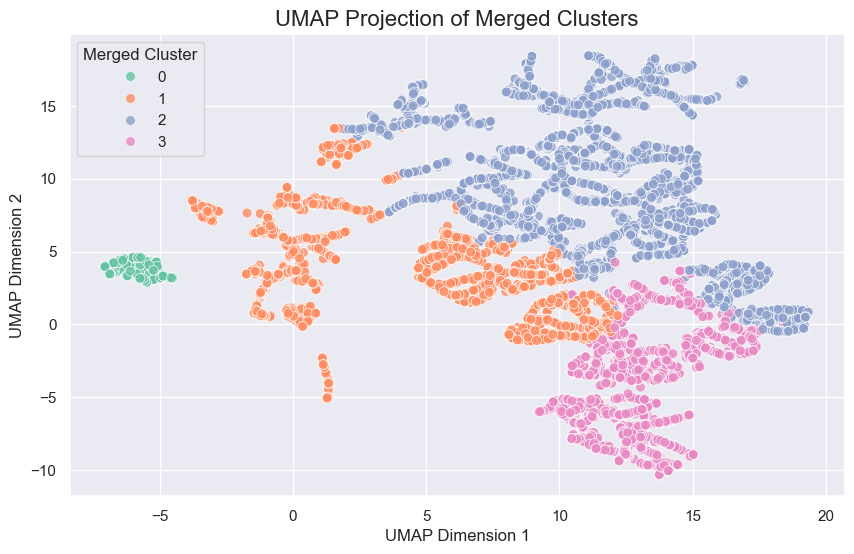

In [98]:
# Make sure to install umap-learn if not already installed
# %pip install umap-learn  # only needed once in the notebook

import umap
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Combine the feature lists used for clustering
col = LO_col + VB_col

# Copy the dataframe
df_ = df.copy()

# Select only the clustering features
X = df_[col]

# Initialize and fit UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# Create a DataFrame for plotting
embedding_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
embedding_df['Merged_Cluster_1'] = df_['Merged_Cluster_1'].values

# Plot UMAP
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=embedding_df,
    x='UMAP1',
    y='UMAP2',
    hue='Merged_Cluster_1',
    palette='Set2',
    s=50,
    alpha=0.8
)
plt.title('UMAP Projection of Merged Clusters', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Merged Cluster')
plt.show()


In [99]:
#  UMAP with different n_neighbors
n_neighbors_values = [2, 15, 100]
umap_results = {}

print("Running UMAP with different n_neighbors values\n")

for n_neigh in n_neighbors_values:
    print(f"Computing UMAP with n_neighbors={n_neigh}")
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neigh,
        min_dist=0.1,
        random_state=42,
        n_jobs=1
    )
    X_umap = reducer.fit_transform(df[col])
    umap_results[n_neigh] = X_umap


Running UMAP with different n_neighbors values

Computing UMAP with n_neighbors=2


c:\Users\calco\anaconda4\envs\dm_project\lib\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Computing UMAP with n_neighbors=15
Computing UMAP with n_neighbors=100


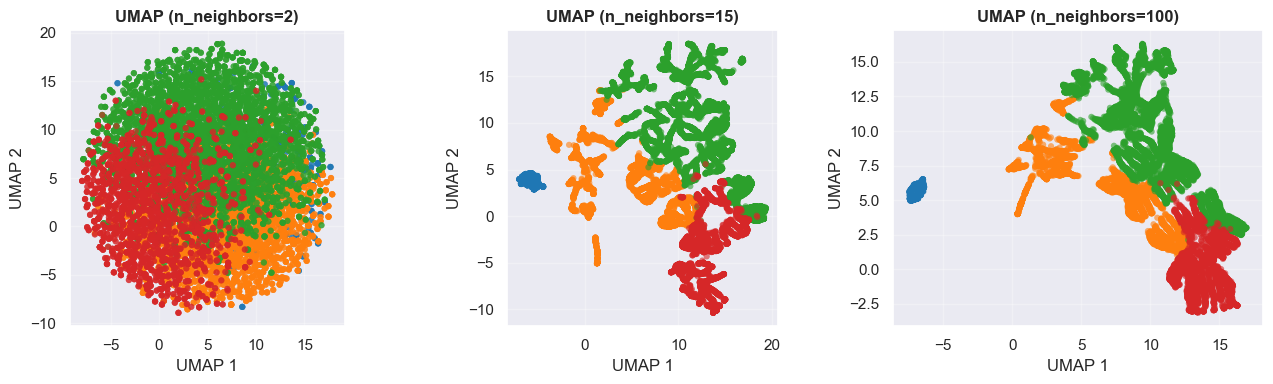

In [100]:
# Visualize n_neighbors comparison
import matplotlib.cm as cm
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

titles = [
    'UMAP (n_neighbors=2)',
    'UMAP (n_neighbors=15)',
    'UMAP (n_neighbors=100)'
]

# Get number of unique clusters
n_clusters = df['Merged_Cluster_1'].nunique()

# Create color map
colors = cm.tab10(np.linspace(0, 1, 10))

for idx, n_neigh in enumerate(n_neighbors_values):
    ax = axes[idx]
    X_umap = umap_results[n_neigh]
    
    # Plot each cluster separately for legend
    for label in sorted(df['Merged_Cluster_1'].unique()):
        mask = df['Merged_Cluster_1'] == label
        ax.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            c=[colors[label]],
            alpha=0.6,
            s=20,
            edgecolors='none',
            label=f'Cluster {label}' if idx == 0 else ''  # Only label first subplot
        )
    
    ax.set_title(titles[idx], fontsize=12, weight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_aspect(1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(right=0.88)  # Make room for legend

plt.show()

In [101]:
#UMAP with different min_dist
min_dist_values = [0.0, 0.1, 0.99]
umap_mindist_results = {}

print("Running UMAP with different min_dist values...\n")

for min_d in min_dist_values:
    print(f"Computing UMAP with min_dist={min_d}")
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=min_d,
        random_state=42,
        n_jobs=1
    )
    X_umap = reducer.fit_transform(df[col])
    umap_mindist_results[min_d] = X_umap


Running UMAP with different min_dist values...

Computing UMAP with min_dist=0.0
Computing UMAP with min_dist=0.1
Computing UMAP with min_dist=0.99


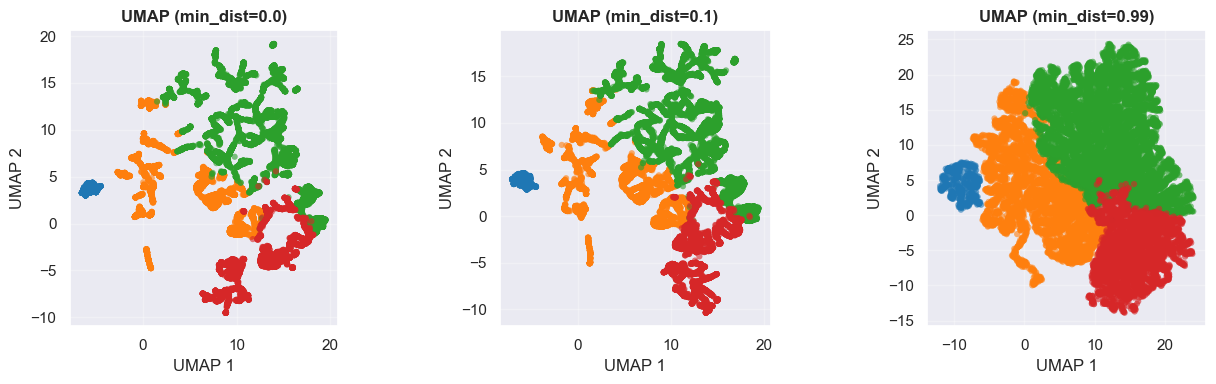

In [102]:
#Visualize min_dist comparison WITH LEGEND
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

titles = [
    'UMAP (min_dist=0.0)',
    'UMAP (min_dist=0.1)',
    'UMAP (min_dist=0.99)'
]

# Get number of unique clusters
n_clusters = df['Merged_Cluster_1'].nunique()

# Create color map
colors = cm.tab10(np.linspace(0, 1, 10))

# Plot UMAP visualizations
for idx, min_d in enumerate(min_dist_values):
    ax = axes[idx]
    X_umap = umap_mindist_results[min_d]
    
    # Plot each cluster separately for legend
    for label in sorted(df['Merged_Cluster_1'].unique()):
        mask = df['Merged_Cluster_1'] == label
        ax.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            c=[colors[label]],
            alpha=0.6,
            s=20,
            edgecolors='none',
            label=f'Cluster {label}' if idx == 0 else ''  # Only label first subplot
        )
    
    ax.set_title(titles[idx], fontsize=12, weight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_aspect(1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(right=0.88)  # Make room for legend

plt.show()

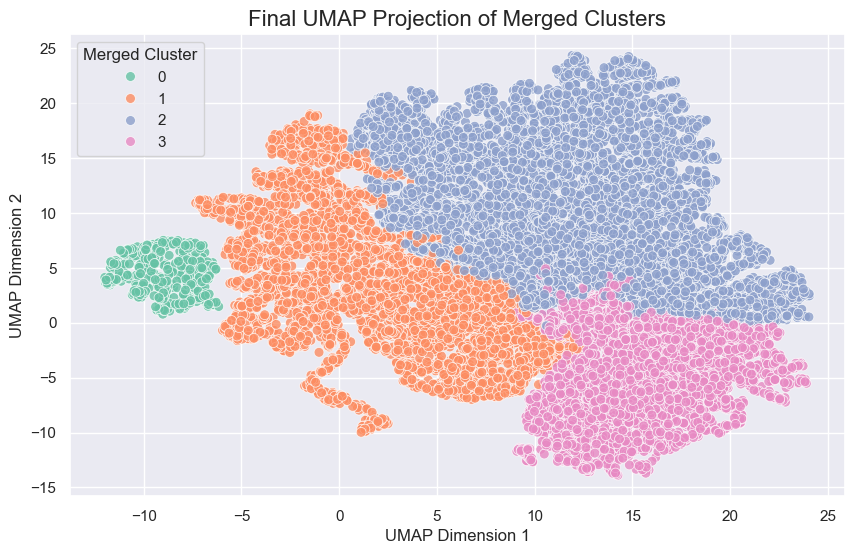

In [103]:
# Now do the final UMAP with chosen parameters (n_neigbors = 15, min_dist=0.1)
reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.99,
        random_state=42,
        n_jobs=1
)
X_umap_final = reducer.fit_transform(df[col])

# Create a DataFrame for plotting
embedding_df_final = pd.DataFrame(X_umap_final, columns=['UMAP1', 'UMAP2'])
embedding_df_final['Merged_Cluster_1'] = df['Merged_Cluster_1'].values
# Plot final UMAP
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=embedding_df_final,
    x='UMAP1',
    y='UMAP2',
    hue='Merged_Cluster_1',
    palette='Set2',
    s=50,
    alpha=0.8
)
plt.title('Final UMAP Projection of Merged Clusters', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Merged Cluster')
plt.show()


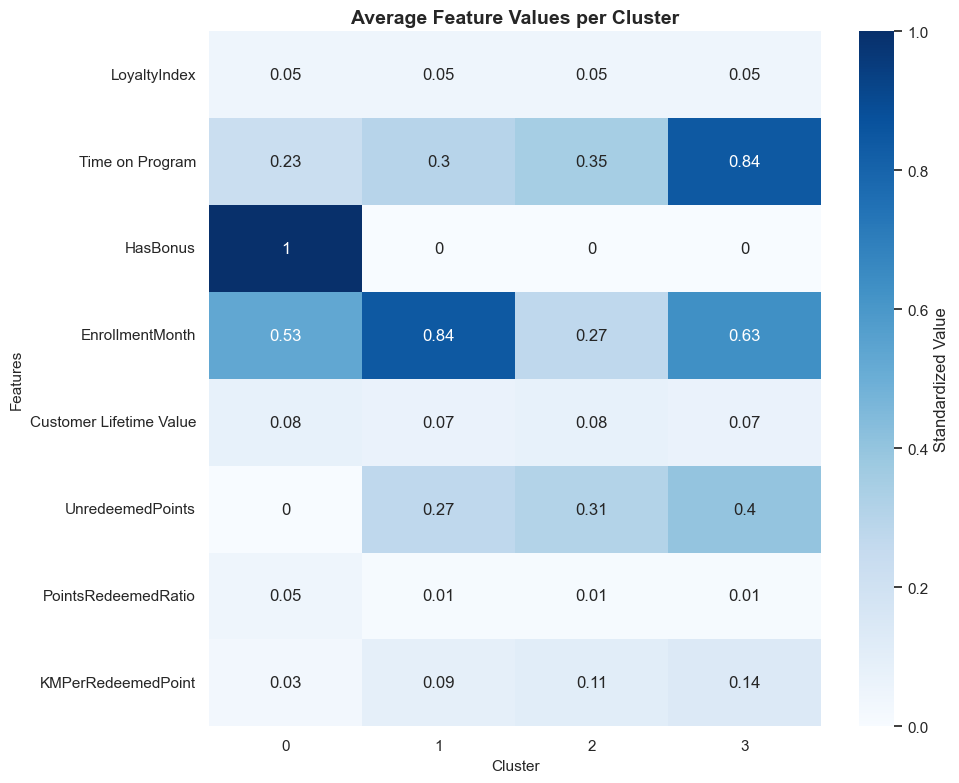

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean values per cluster
corr = df.groupby('Merged_Cluster_1')[col].mean().round(2)
corr = corr.T

# Single figure with BLUE colormap
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, cmap='Blues', 
            cbar_kws={'label': 'Standardized Value'})
plt.title('Average Feature Values per Cluster', 
          fontsize=14, weight='bold')
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Features', fontsize=11)

plt.tight_layout()
plt.show()

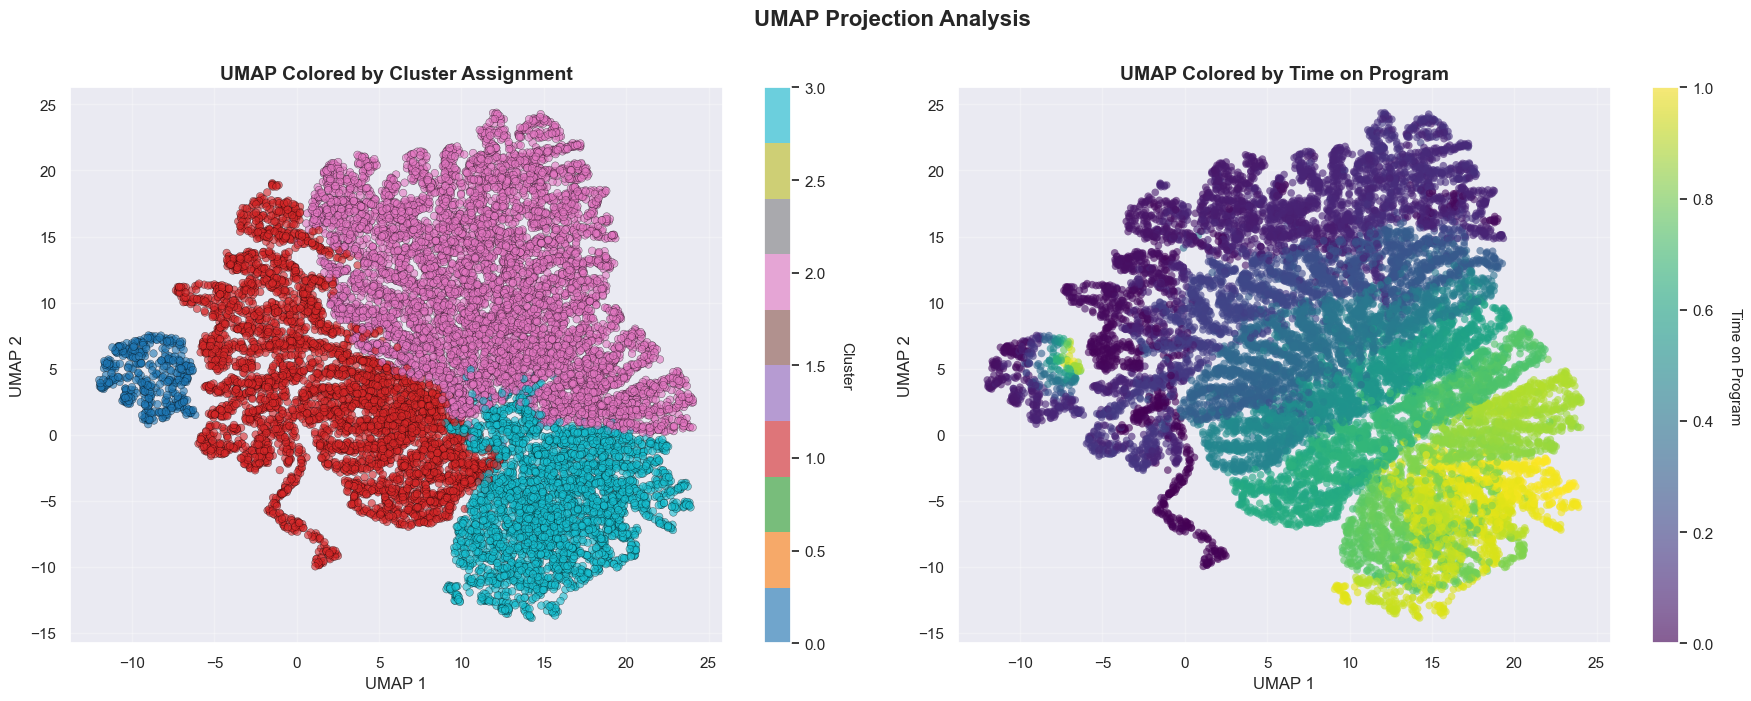

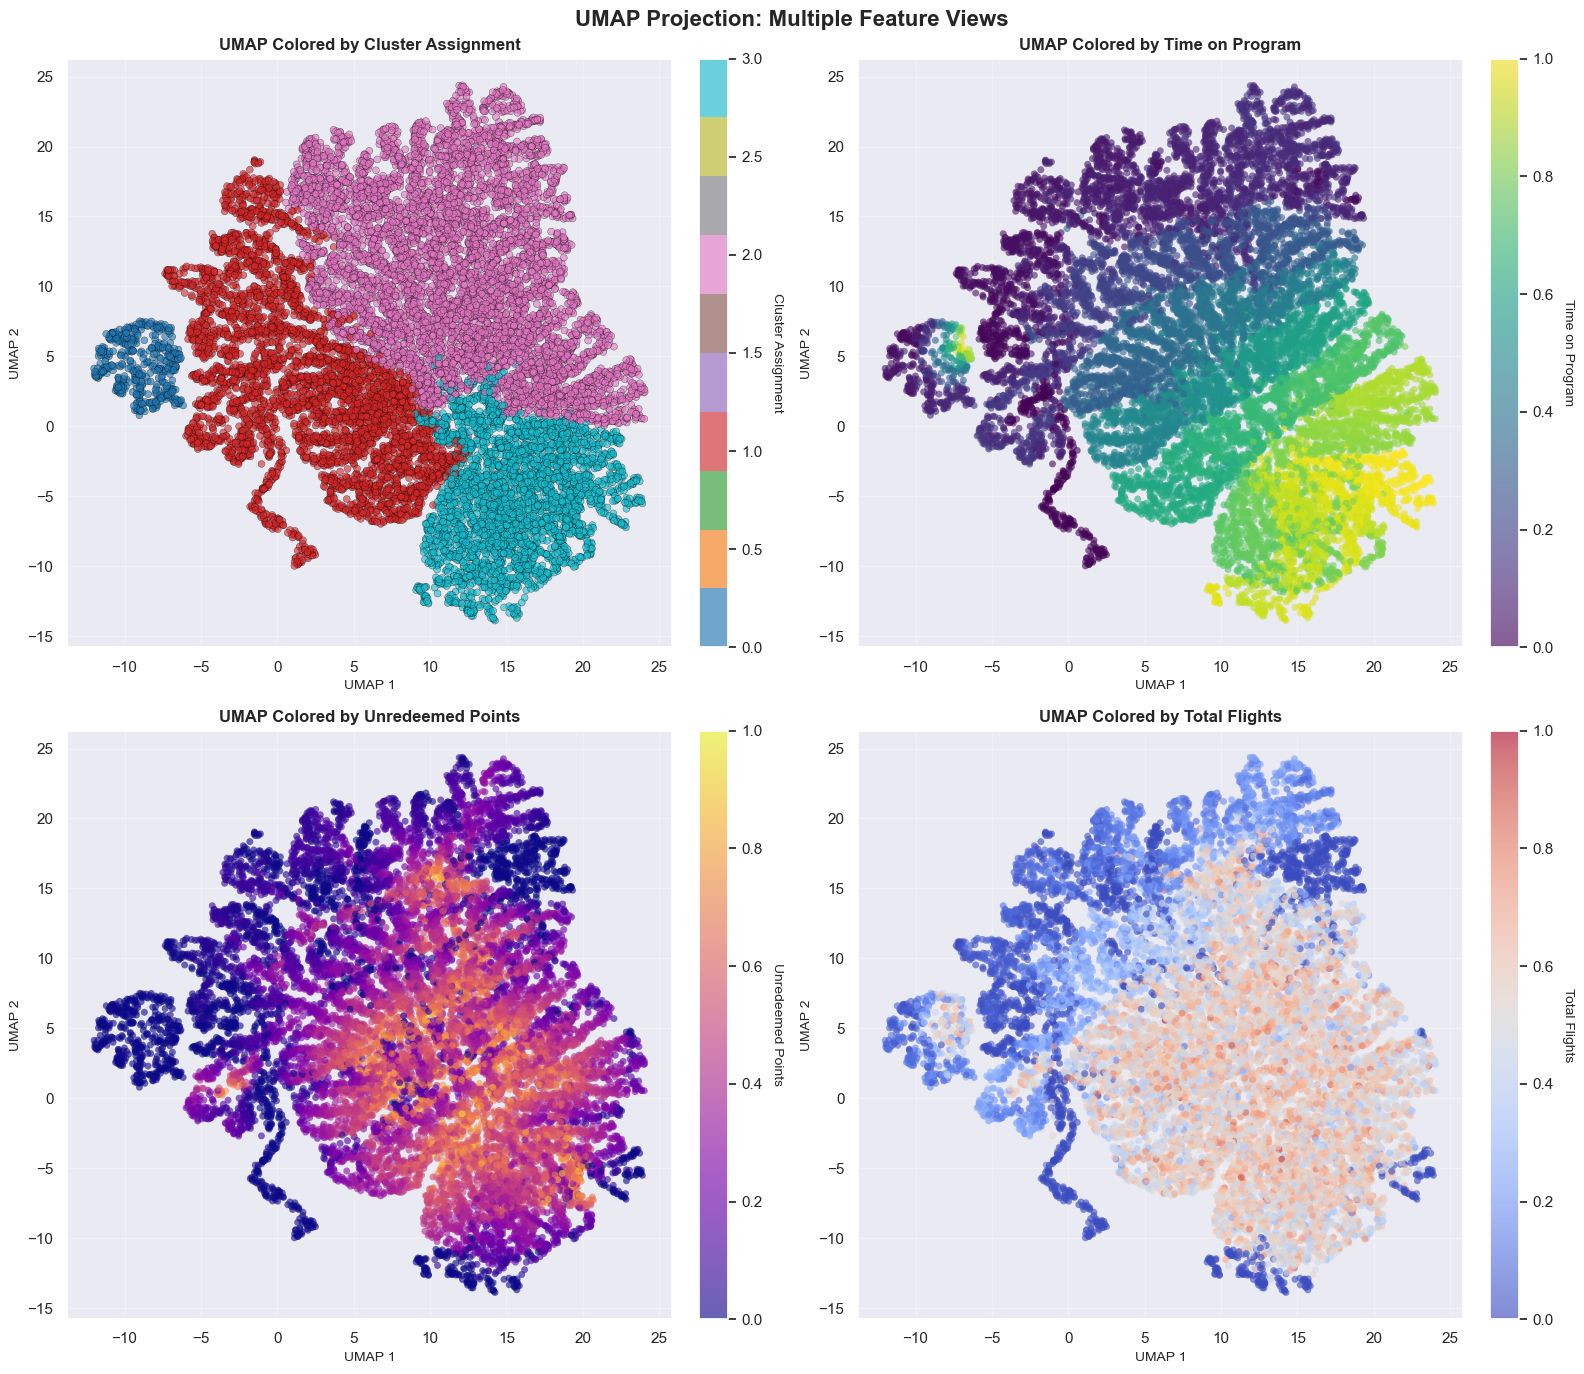

In [119]:
import matplotlib.pyplot as plt
umap_x = X_umap_final[:, 0]

umap_y = X_umap_final[:, 1]
# Option 1: Show cluster assignments (most informative!)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Left plot: Colored by cluster
scatter1 = axes[0].scatter(
    umap_x,
    umap_y,
    c=df['Merged_Cluster_1'],
    cmap='tab10',
    alpha=0.6,
    s=30,
    edgecolors='black',
    linewidths=0.3
)
axes[0].set_title('UMAP Colored by Cluster Assignment', fontsize=14, weight='bold')
axes[0].set_xlabel('UMAP 1', fontsize=12)
axes[0].set_ylabel('UMAP 2', fontsize=12)
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster', fontsize=11, rotation=270, labelpad=20)

# Right plot: Colored by Time on Program (the one that showed variation)
scatter2 = axes[1].scatter(
    umap_x,
    umap_y,
    c=df['Time on Program'],
    cmap='viridis',
    alpha=0.6,
    s=30,
    edgecolors='none'
)
axes[1].set_title('UMAP Colored by Time on Program', fontsize=14, weight='bold')
axes[1].set_xlabel('UMAP 1', fontsize=12)
axes[1].set_ylabel('UMAP 2', fontsize=12)
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Time on Program', fontsize=11, rotation=270, labelpad=20)

plt.suptitle('UMAP Projection Analysis', fontsize=16, weight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Option 2: If you want to see multiple meaningful features
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Features that should show actual variation
features_to_plot = [
    ('Merged_Cluster_1', 'Cluster Assignment', 'tab10'),
    ('Time on Program', 'Time on Program', 'viridis'),
    ('UnredeemedPoints', 'Unredeemed Points', 'plasma'),
    ('TotalFlights', 'Total Flights', 'coolwarm')
]

axes_flat = axes.flatten()

for idx, (feature, label, cmap) in enumerate(features_to_plot):
    ax = axes_flat[idx]
    
    scatter = ax.scatter(
        umap_x,
        umap_y,
        c=df[feature],
        cmap=cmap,
        alpha=0.6,
        s=25,
        edgecolors='black' if feature == 'Merged_Cluster_1' else 'none',
        linewidths=0.3 if feature == 'Merged_Cluster_1' else 0
    )
    
    ax.set_title(f'UMAP Colored by {label}', fontsize=12, weight='bold')
    ax.set_xlabel('UMAP 1', fontsize=10)
    ax.set_ylabel('UMAP 2', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label(label, fontsize=10, rotation=270, labelpad=15)

plt.suptitle('UMAP Projection: Multiple Feature Views', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

## (LO + VB) + SEASONALITY

In [124]:
SA_clusters = pd.read_csv("df_with_seasonal_clusters.csv")

In [125]:
SA_clusters

kmeans_cluster
0                   2
1                   1
2                   1
3                   1
4                   1
...               ...
16569               2
16570               1
16571               0
16572               1
16573               1

[16574 rows x 1 columns]

In [130]:
SA_col = ['sr_jan', 'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun',
       'sr_jul', 'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec']
SA_col

['sr_jan',
 'sr_feb',
 'sr_mar',
 'sr_apr',
 'sr_may',
 'sr_jun',
 'sr_jul',
 'sr_aug',
 'sr_sep',
 'sr_oct',
 'sr_nov',
 'sr_dec']

In [127]:
df["SA_CLUSTER"] = SA_clusters["kmeans_cluster"]

In [131]:
# Get centroids of clusters
df_centroids_2 = df.groupby(['Merged_Cluster_1', 'SA_CLUSTER'])\
    [LO_col+VB_col+SA_col].mean()


df_centroids_2

LoyaltyIndex  Time on Program  HasBonus  \
Merged_Cluster_1 SA_CLUSTER                                            
0                0               0.046763         0.084183       1.0   
                 1               0.049258         0.289402       1.0   
                 2               0.046525         0.213590       1.0   
                 3               0.060582         0.042957       1.0   
1                0               0.059307         0.079327       0.0   
                 1               0.039821         0.303077       0.0   
                 2               0.049992         0.341140       0.0   
                 3               0.076620         0.038420       0.0   
2                0               0.053861         0.121071       0.0   
                 1               0.041882         0.353946       0.0   
                 2               0.048513         0.367466       0.0   
                 3               0.158814         0.072008       0.0   
3                1               0.044194         0.848146       0.0   
                 2               0.048326         0.836751       0.0   

                             EnrollmentMonth  Customer Lifetime Value  \
Merged_Cluster_1 SA_CLUSTER                                             
0                0                  0.584139                 0.065937   
                 1                  0.481385                 0.080105   
                 2                  0.554336                 0.080880   
                 3                  0.740741                 0.078920   
1                0                  0.700153                 0.075350   
                 1                  0.848606                 0.075194   
                 2                  0.844962                 0.073716   
                 3                  0.771242                 0.072736   
2                0                  0.461641                 0.069766   
                 1                  0.264251                 0.076514   
                 2                  0.260505                 0.073833   
                 3                  0.500000                 0.058871   
3                1                  0.626193                 0.075615   
                 2                  0.623719                 0.071514   

                             UnredeemedPoints  PointsRedeemedRatio  \
Merged_Cluster_1 SA_CLUSTER                                          
0                0                   0.000000             0.050100   
                 1                   0.000000             0.046610   
                 2                   0.000000             0.054175   
                 3                   0.000000             0.106744   
1                0                   0.088723             0.004096   
                 1                   0.262288             0.006292   
                 2                   0.316633             0.007612   
                 3                   0.038746             0.001270   
2                0                   0.140438             0.006078   
                 1                   0.291681             0.006827   
                 2                   0.350253             0.008308   
                 3                   0.067272             0.006310   
3                1                   0.376294             0.007802   
                 2                   0.433285             0.008953   

                             KMPerRedeemedPoint    sr_jan    sr_feb    sr_mar  \
Merged_Cluster_1 SA_CLUSTER                                                     
0                0                     0.028959  0.004248  0.007391  0.005291   
                 1                     0.029839  0.097351  0.075716  0.117730   
                 2                     0.027993  0.027093  0.030530  0.035310   
                 3                     0.021098  0.005051  0.005051  0.005892   
1                0                     0.022480  0.010648  0.012374  0.009947   
                 1 

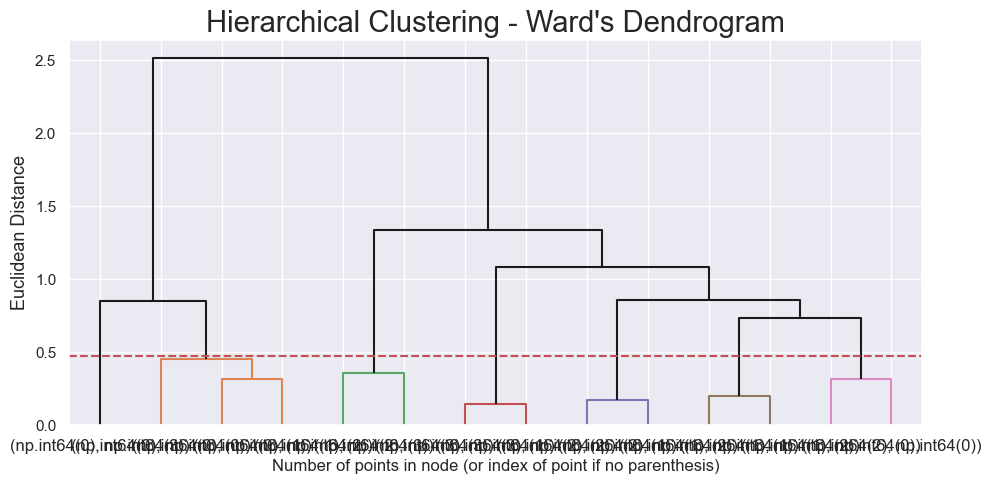

In [132]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids_2)

# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 0.47
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids_2.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [133]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=7
)
hclust_labels = hclust.fit_predict(df_centroids_2)
df_centroids_2['hclust_labels'] = hclust_labels

df_centroids_2  # centroid's cluster labels

LoyaltyIndex  Time on Program  HasBonus  \
Merged_Cluster_1 SA_CLUSTER                                            
0                0               0.046763         0.084183       1.0   
                 1               0.049258         0.289402       1.0   
                 2               0.046525         0.213590       1.0   
                 3               0.060582         0.042957       1.0   
1                0               0.059307         0.079327       0.0   
                 1               0.039821         0.303077       0.0   
                 2               0.049992         0.341140       0.0   
                 3               0.076620         0.038420       0.0   
2                0               0.053861         0.121071       0.0   
                 1               0.041882         0.353946       0.0   
                 2               0.048513         0.367466       0.0   
                 3               0.158814         0.072008       0.0   
3                1               0.044194         0.848146       0.0   
                 2               0.048326         0.836751       0.0   

                             EnrollmentMonth  Customer Lifetime Value  \
Merged_Cluster_1 SA_CLUSTER                                             
0                0                  0.584139                 0.065937   
                 1                  0.481385                 0.080105   
                 2                  0.554336                 0.080880   
                 3                  0.740741                 0.078920   
1                0                  0.700153                 0.075350   
                 1                  0.848606                 0.075194   
                 2                  0.844962                 0.073716   
                 3                  0.771242                 0.072736   
2                0                  0.461641                 0.069766   
                 1                  0.264251                 0.076514   
                 2                  0.260505                 0.073833   
                 3                  0.500000                 0.058871   
3                1                  0.626193                 0.075615   
                 2                  0.623719                 0.071514   

                             UnredeemedPoints  PointsRedeemedRatio  \
Merged_Cluster_1 SA_CLUSTER                                          
0                0                   0.000000             0.050100   
                 1                   0.000000             0.046610   
                 2                   0.000000             0.054175   
                 3                   0.000000             0.106744   
1                0                   0.088723             0.004096   
                 1                   0.262288             0.006292   
                 2                   0.316633             0.007612   
                 3                   0.038746             0.001270   
2                0                   0.140438             0.006078   
                 1                   0.291681             0.006827   
                 2                   0.350253             0.008308   
                 3                   0.067272             0.006310   
3                1                   0.376294             0.007802   
                 2                   0.433285             0.008953   

                             KMPerRedeemedPoint    sr_jan    sr_feb  ...  \
Merged_Cluster_1 SA_CLUSTER                                          ...   
0                0                     0.028959  0.004248  0.007391  ...   
                 1                     0.029839  0.097351  0.075716  ...   
                 2                     0.027993  0.027093  0.030530  ...   
                 3                     0.021098  0.005051  0.005051  ...   
1                0                     0.022480  0.010648  0.012374  ...   
                 1                     0.094487  0.060

In [134]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids_2['hclust_labels'].to_dict()
cluster_mapper

{(0, 0): 0,
 (0, 1): 0,
 (0, 2): 0,
 (0, 3): 5,
 (1, 0): 1,
 (1, 1): 6,
 (1, 2): 6,
 (1, 3): 2,
 (2, 0): 1,
 (2, 1): 4,
 (2, 2): 4,
 (2, 3): 2,
 (3, 1): 3,
 (3, 2): 3}

In [136]:
df_2 = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_2['Merged_Clusters_2'] = df_2.apply(
    lambda row: cluster_mapper[
        (row['Merged_Cluster_1'], row['SA_CLUSTER'])
    ], axis=1
)

df_2

PointsRedeemedRatio  FlightsWithCompanionsRatio  AvgDistancePerFlight  \
0                 0.011660                    0.200000              0.053732   
1                 0.016634                    0.224490              0.031560   
2                 0.003408                    0.241706              0.046686   
3                 0.010644                    0.157407              0.076975   
4                 0.007622                    0.276243              0.054122   
...                    ...                         ...                   ...   
16569             0.005174                    0.275862              0.053304   
16570             0.000000                    0.000000              0.000000   
16571             0.007082                    0.321429              0.064760   
16572             0.000000                    0.090909              0.054571   
16573             0.015725                    0.121547              0.043475   

       KMPerRedeemedPoint  UnredeemedPoints  LoyaltyIndex  \
0                0.101416          0.497569      0.053931   
1                0.071096          0.232192      0.031779   
2                0.347041          0.587235      0.046867   
3                0.111097          0.361054      0.077074   
4                0.155144          0.491619      0.054280   
...                   ...               ...           ...   
16569            0.228518          0.774448      0.053528   
16570            0.000000          0.000000      0.000000   
16571            0.166956          0.279639      0.064836   
16572            0.000000          0.080725      0.054590   
16573            0.075201          0.252312      0.043640   

                           CustomerSegment  HasBonus  TotalFlights    sr_jan  \
0      Moderate traveler and high redeemed       0.0      0.655977  0.026667   
1            Low traveler and low redeemed       0.0      0.714286  0.077551   
2       Moderate traveler and low redeemed       0.0      0.615160  0.094787   
3          High traveler and high redeemed       0.0      0.314869  0.000000   
4      Moderate traveler and high redeemed       0.0      0.527697  0.022099   
...                                    ...       ...           ...       ...   
16569  Moderate traveler and high redeemed       0.0      0.760933  0.099617   
16570        Low traveler and low redeemed       0.0      0.000000  0.000000   
16571      High traveler and high redeemed       0.0      0.244898  0.000000   
16572  Moderate traveler and high redeemed       0.0      0.064140  0.000000   
16573   Moderate traveler and low redeemed       0.0      0.527697  0.005525   

       ...  Time on Program  Cancelled  Reenroll  EnrollmentType  \
0      ...         0.354564          N       0.0        Standard   
1      ...         0.860852          N       0.0        Standard   
2      ...         0.358621          N       0.0        Standard   
3      ...         0.503854          N       0.0        Standard   
4      ...         0.736714          N       0.0        Standard   
...    ...              ...        ...       ...             ...   
16569  ...         0.681947          N       0.0        Standard   
16570  ...         0.950101          N       0.0        Standard   
16571  ...         0.212170          N       0.0        Standard   
16572  ...         0.071805          N       0.0        Standard   
16573  ...         0.129817          N       0.0  2021 Promotion   

       Customer Lifetime Value  VALUE_BASED_CLUSTER  LOYALTY_CLUSTER  \
0                     0.073946                    0                0   
1                     0.012155                    0                0   
2                     0.011545                    1                0   
3                     0.027909                    0                1   
4                     0.058015                    0                0   
...                        ...                  ...              ...   
16569                 0.066219 

In [137]:
# Merge cluster contigency table
# Getting size of each final cluster
df_counts_2 = df_2.groupby('Merged_Clusters_2')\
    .size()\
    .to_frame()

df_counts_2

0
Merged_Clusters_2      
0                   431
1                   443
2                   167
3                  3688
4                  7534
5                    27
6                  4284

In [138]:
df["Merged_Cluster_2"] = df_2["Merged_Clusters_2"]